# Summary
This document corresponds to Exercise 2 of [this file](https://github.com/PerformanceEstimation/Learning-Performance-Estimation/blob/main/Exercises/Course.pdf).

We first install a few packages.

In [2]:
!pip install sympy
!pip install cvxpy

## Closed-form solutions for the LMI?

Let us start by trying to solve this LMI numerically for a few values of $\mu$, $L$, and $\gamma_k$.
The following code implements the LMI.

### Numerical solutions to the LMI

In [52]:
import cvxpy as cp
def lmi_convergence_distance(L, mu, gamma):

    # Write the LMI.
    S = cp.Variable((2, 2)) # this is the matrix S
    l1 = cp.Variable()      # this is the multiplier (lambda1 == lambda2) which we denote l1
    tau = cp.Variable()     # this is the objective
    
    s11 = tau-1+l1*L*mu/(L-mu)
    s12 = gamma-l1*(L+mu)/2/(L-mu)
    s22 = l1/(L-mu)-gamma**2
    
    constraints = [S >> 0,
                   S[0,0] == s11,
                   S[1,1] == s22,
                   S[0,1] == s12,
                   S[1,0] == s12,
                   l1 >= 0]
    
    prob = cp.Problem(cp.Minimize(tau), constraints)
    prob.solve()
    return tau.value, l1.value, S.value

The following code solves the LMI for a grid of $\gamma_k$'s.

In [69]:
import numpy as np
import matplotlib.pyplot as plt

nb_test = 50
mu = .1
L = 1
gamma = np.linspace(-1., 3., num=nb_test)

l1_list = list()
tau_list = list()
S_list = list()

for i in range(nb_test):
    tau,l1,S = lmi_convergence_distance(L, mu, gamma[i])
    l1_list.append(l1[()])
    tau_list.append(tau[()])
    S_list.append(S)

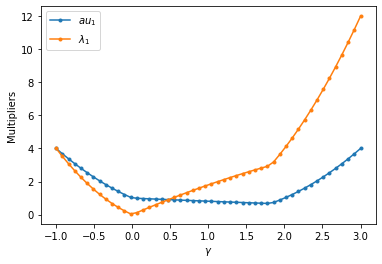

In [59]:
plt.plot(gamma, tau_list, '.-',label='$\tau_1$')
plt.plot(gamma, l1_list, '.-',label='$\lambda_1$')

plt.xlabel('$\gamma$')
plt.ylabel('Multipliers')
plt.legend()
plt.show()

A useful information about $S$ is its eigenvalues.

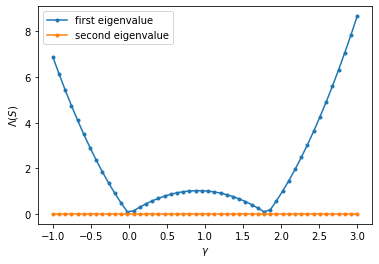

In [91]:
firsteig_list = list()
seceig_list = list()

for i in range(nb_test):
    eigsV, _ = np.linalg.eigh(S_list[i])
    firsteig_list.append(np.max(eigsV))
    seceig_list.append(np.min(eigsV))

plt.plot(gamma, firsteig_list, '.-',label='first eigenvalue')
plt.plot(gamma, seceig_list, '.-',label='second eigenvalue')

plt.xlabel('$\gamma$')
plt.ylabel('$\Lambda(S)$')
plt.legend()
plt.show()

In case you have a candidate expression for $\tau(\mu,L,\gamma_k)$, compare it with the numerics?

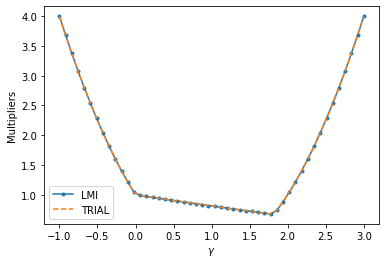

In [51]:
tau_candidates = [ np.max([(1-gamma[i]*L)**2,(1-gamma[i]*mu)**2]) for i in range(nb_test)]
plt.plot(gamma, tau_list, '.-',label='LMI')
plt.plot(gamma, tau_candidates, '--',label='TRIAL')

plt.xlabel('$\gamma$')
plt.ylabel('Multipliers')
plt.legend()

plt.show()

### Closed-form solutions to the LMI?

As we saw numerically, the matrix $S$ has rank $1$ for most values of the step-sizes!
As the problem of finding a bound on the convergence rate $\frac{\|x_{k+1}-x_\star\|^2}{\|x_k-x_\star\|^2}$ corresponds to a linear problem with an LMI constraint, it is natural that the optimal solution is on the boundary of the feasible set, and we can use that for solving the problem in closed-form.

We use a bit of symbolic computation below for simplicity.

Complete the following code with the values in $S$:

In [99]:
import sympy as sm

tau = sm.Symbol('tau')
l1 = sm.Symbol('l1')
gamma = sm.Symbol('gamma')
L = sm.Symbol('L')
mu = sm.Symbol('mu')

S = sm.Matrix([[tau-1+l1*L*mu/(L-mu), gamma-l1*(L+mu)/2/(L-mu)], [gamma-l1*(L+mu)/2/(L-mu), l1/(L-mu)-gamma**2]])

For making $S$ rank defficient, let's choose $\tau$ for cancelling out the determinant:

In [102]:
candidate_tau=sm.solve(S.det(),tau)
candidate_tau[0]

l1*(4*L*gamma**2*mu - 4*L*gamma + L*l1 - 4*gamma*mu - l1*mu + 4)/(4*(-L*gamma**2 + gamma**2*mu + l1))

There are two possibilities for choosing $\lambda_1$:
- on the boundary of the PSD cone ($S=0$),
- minimize $\tau$ (and verify that the corresponding $(\lambda_1,\tau,S)$ is feasible for the LMI afterwards).

Because we observed numerically that $S$ was rank $1$ for most choices of stepsizes, let's focus on the second possibility.

In [105]:
dtau=sm.simplify(sm.diff(candidate_tau[0],l1)) #differentiate tau with respect to lambda_1
dtau

(-l1*(4*L*gamma**2*mu - 4*L*gamma + L*l1 - 4*gamma*mu - l1*mu + 4) + (-L*gamma**2 + gamma**2*mu + l1)*(4*L*gamma**2*mu - 4*L*gamma + L*l1 - 4*gamma*mu - l1*mu + l1*(L - mu) + 4))/(4*(-L*gamma**2 + gamma**2*mu + l1)**2)

In [108]:
l1sol=sm.solve(dtau,l1) # solve dtau/dlambda_1 == 0 in lambda1
l1sol # show the two possibilities!

[2*gamma*(L*gamma - 1), 2*gamma*(-gamma*mu + 1)]

The corresponding "final" expressions for $\tau$ that must be checked are therefore:

In [111]:
exprtau1=sm.simplify(candidate_tau[0].subs(l1,l1sol[0]))
exprtau1.factor()

(L*gamma - 1)**2

In [112]:
exprtau2=sm.simplify(candidate_tau[0].subs(l1,l1sol[1]))
exprtau2.factor()

(gamma*mu - 1)**2